<a href="https://colab.research.google.com/github/RuslanYusup/EDA_CAR/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Пробуем алгоритм прогнозирования Prophet с предсказанием количество постов на Хабре - классческая Kaggle задача

In [4]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем нужные нам библиотеки

In [61]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

1. Загрузим данные и посмотрим на них, возможно отработаем признаки

In [50]:
df = pd.read_csv('howpop_train.csv')
df.head()

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,-0.792687,-1.344075,-2.436871
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,-0.485214,-0.831946,-1.873193
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,0.446090,1.794023,0.574656
3,https://habrahabr.ru/post/18291/,habrahabr.ru,18291,2008-01-02 01:32:00,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",102,36,5700,72.0,3.0,1.627469,1.300050,1.167375
4,https://geektimes.ru/post/18294/,geektimes.ru,18294,2008-01-02 14:34:00,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,230,6,1400,73.0,15.0,1.362397,0.961094,2.020356


Нас интересуют дата публикации и url, удалим другие данные и сгруппируем по дате публикации

In [51]:
df['published'] = pd.to_datetime(df.published)
df = df[['published', 'url']]
df = df.drop_duplicates()
agg_df = df.groupby('published')[['url']].count()
agg_df.columns = ['post']
agg_df.head()

,post
published,
2008-01-01 18:19:00,1
2008-01-01 18:30:00,1
2008-01-01 18:34:00,1
2008-01-02 01:32:00,1
2008-01-02 14:34:00,1


посмотрим распределение постов

In [52]:
agg_df.post.value_counts()

1     126685
2       3480
3        106
4         12
5          3
20         1
30         1
6          1
16         1
39         1
Name: post, dtype: int64

С помощью resample сделаем группу по столбцу, тип которого Дата/время. Параметры D- день, W - неделя, 3D - 3 дня. Визуализируем с помощью функции ploty_df

In [53]:

def ploty_df(df, title = ''):
  data = []

  for columns in df.columns:
    trace = go.Scatter(
        x = df.index,
        y = df[columns],
        mode = 'lines',
        name = columns
    )
    data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)


In [67]:
ploty_df(agg_df.resample('W').apply(sum), title = 'Опубликованные посты на Хабр')

Готовим данные для модели Prophet, там должны быть две колонки, ds - поле со временем, y - таргет, предсказания лучше делать по месячным данным по годам

In [69]:
predictions = 30

df_m = agg_df.reset_index()
df_m.columns = ['ds', 'y']
df_m.tail()

,ds,y
130286,2016-10-31 21:45:00,1
130287,2016-10-31 22:44:00,1
130288,2016-10-31 23:26:00,1
130289,2016-10-31 23:52:00,1
130290,2016-10-31 23:56:00,1


In [ ]:
# отрезаем часть для валидации - 30 
prediction = 30
df_train = df_model[:-prediction]

In [56]:
model = Prophet()
model.fit(df_train)

Создаем сет для предсказания

In [57]:
future = model.make_future_dataframe(periods=30)
future.tail() # как убрать время? 

,ds
130286,2016-11-26 16:28:00
130287,2016-11-27 16:28:00
130288,2016-11-28 16:28:00
130289,2016-11-29 16:28:00
130290,2016-11-30 16:28:00


In [60]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
130286,2016-11-26 16:28:00,1.017942,0.733664,1.321581,1.017942,1.017942,-0.003256,-0.003256,-0.003256,0.015304,...,-0.017428,-0.017428,-0.017428,-0.001132,-0.001132,-0.001132,0.0,0.0,0.0,1.014686
130287,2016-11-27 16:28:00,1.017910,0.743797,1.326523,1.017910,1.017910,0.006462,0.006462,0.006462,0.015304,...,-0.008037,-0.008037,-0.008037,-0.000805,-0.000805,-0.000805,0.0,0.0,0.0,1.024372
130288,2016-11-28 16:28:00,1.017877,0.769188,1.330022,1.017872,1.017879,0.021399,0.021399,0.021399,0.015304,...,0.006538,0.006538,0.006538,-0.000443,-0.000443,-0.000443,0.0,0.0,0.0,1.039277
130289,2016-11-29 16:28:00,1.017845,0.741560,1.337719,1.017835,1.017847,0.022560,0.022560,0.022560,0.015304,...,0.007312,0.007312,0.007312,-0.000056,-0.000056,-0.000056,0.0,0.0,0.0,1.040405
130290,2016-11-30 16:28:00,1.017813,0.745453,1.329193,1.017796,1.017816,0.019415,0.019415,0.019415,0.015304,...,0.003767,0.003767,0.003767,0.000343,0.000343,0.000343,0.0,0.0,0.0,1.037227


Модель выдает не только прогноз, а также о границах признаков

Визуализируем 

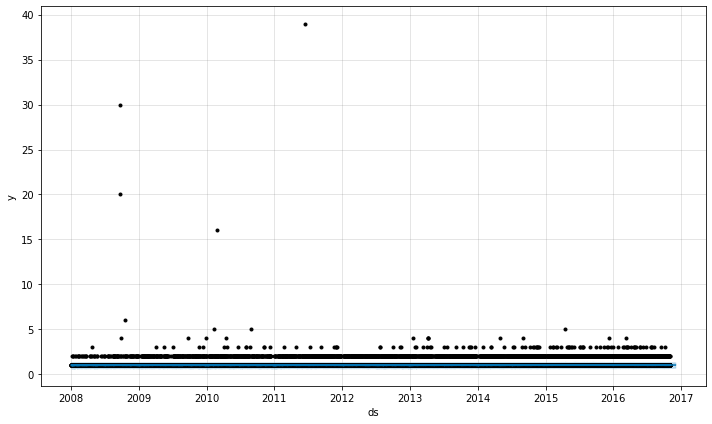

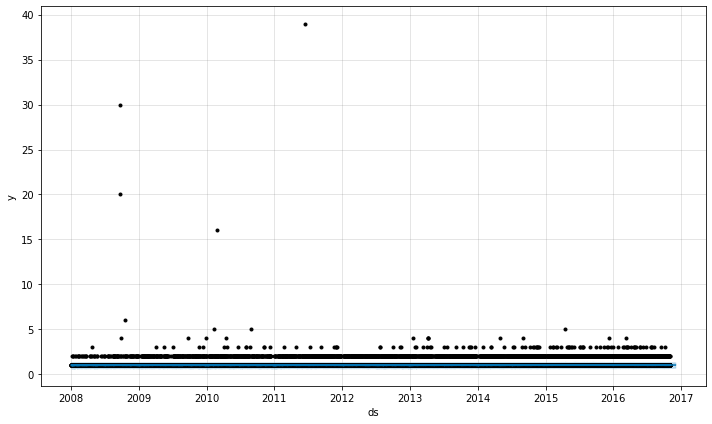

In [72]:
model.plot(forecast)

Посмотрим отдельно на компоненты ряда

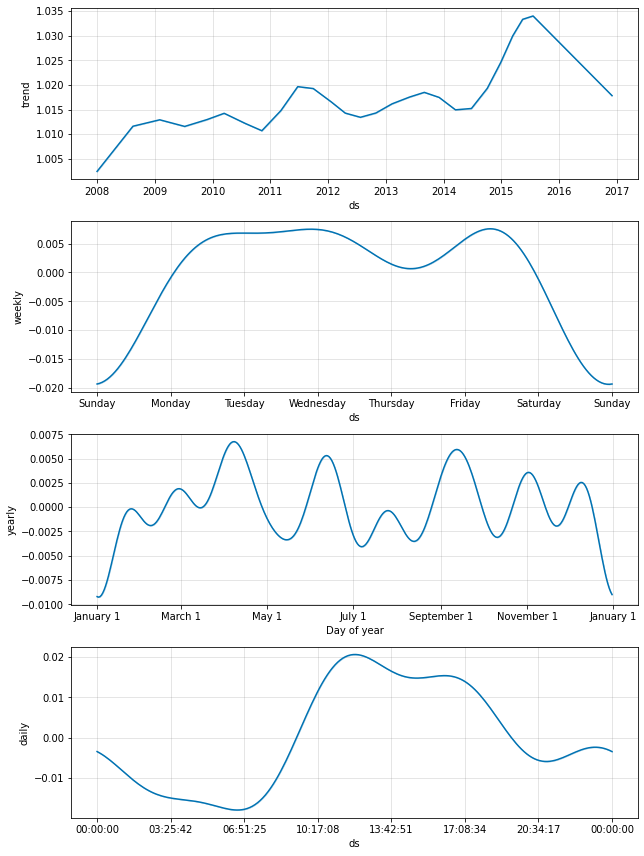

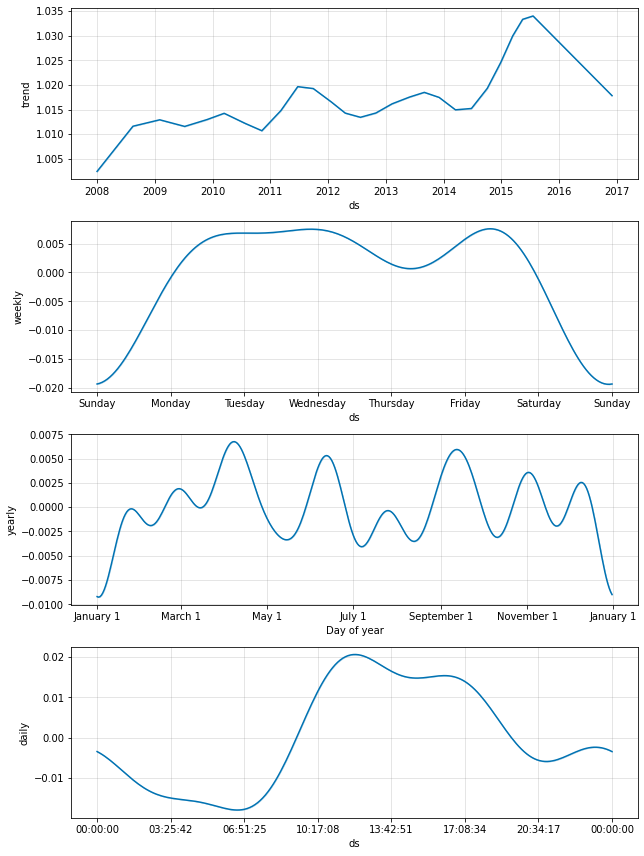

In [71]:
model.plot_components(forecast)

Оценка качества модели, выведем еще раз признаки нагенерированные

In [46]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


Объеденим предсказания с реальными данными

In [73]:
total = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds')) # грусть печаль


KeyError: ignored

Строим прогноз на отложенных 30 днях и измеряем качество модели

In [ ]:
total['e'] = total['y'] - total['yhat']
total['p'] = 100*total['e']/total['y']
np.mean(abs(total[-predictions:]['p'])), np.mean(abs(total[-predictions:]['e']))

# Новый раздел